In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.optimize import minimize
from scipy.optimize import fmin_cg
from sklearn.linear_model import LogisticRegression

mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']

# Display Data

400

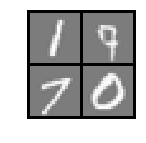

In [2]:
def displayData(x):
    
    if len(x.shape) ==1: num_image,pixels = 1, x.shape[0]
    else:    num_image, pixels = x.shape[0], x.shape[1]
    
    pix_square = int(np.sqrt(pixels))
    num_row = int(np.floor(np.sqrt(num_image)))
    num_col = int(np.ceil(num_image/num_row))
    
    pad = 1;
    img = formatPixels(x, num_row, num_col,pix_square,num_image)
    plt.figure(figsize=(num_row,num_col))
    plt.imshow(img,cmap = "gray");
    plt.axis('off');
    return pixels

def formatPixels(x, num_row, num_col,pix_square,num_image):
    pad =1;
    pix_col = pad + num_col*(pix_square + pad);
    pix_row = pad + num_row*(pix_square + pad);
    num = 0;
    img = -1*np.ones([pix_row,pix_col])
    for i in range(num_row): 
        for j in range(num_col):
            c = pad*(i+1) + i*pix_square
            img[c:c+pix_square,(pad*(j+1) + j*pix_square)+np.arange(pix_square)] = x[num,:].reshape([pix_square,pix_square]).T
            num += 1
            if num>=num_image: break;
    return img

x = X[np.random.randint(y.size, size=4),:]
displayData(x)

### Load initialised weights

In [3]:
mat = scipy.io.loadmat('ex4weights.mat')
theta1 = mat['Theta1']
theta2 = mat['Theta2']
nn_para = np.r_[theta1.ravel(),theta2.ravel()].reshape([-1,1])
input_layer_size = theta1.shape[1] - 1;
hidden_layer_size = theta2.shape[1] - 1;
num_labels = len(np.unique(y))

### Cost Function

In [4]:
def sigmoid(z):
    return (1/(1+np.exp(-z)))

def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

def randInitializeWeights(input_layer, output_layer):
    epsilon_init = 0.12;
    rand = np.random.uniform(-epsilon_init,epsilon_init,[output_layer, input_layer+1])    
    return rand

def nnCost(nn_para,hidden_layer_size, X,y, reg):
    m = y.size;
    input_layer_size = X.shape[1]
    
    theta1 = nn_para[:hidden_layer_size*(input_layer_size+1)].reshape([hidden_layer_size, -1])
    theta2 = nn_para[hidden_layer_size*(input_layer_size+1):].reshape([-1, hidden_layer_size+1])
    
    a1 = np.c_[np.ones([m,1]), X]
    a2 = np.c_[np.ones([m,1]), sigmoid(a1.dot(theta1.T))]
    a3 = sigmoid(a2.dot(theta2.T))
    
    # Theta to be used in regularization
    regTheta1 = theta1[:,1:]
    regTheta2 = theta2[:,1:]
    
    n_values = np.max(y)
    y = np.eye(n_values)[y.flatten()-1]
    
    cost = -1/m*sum(sum(np.multiply(y,np.log(a3)) + np.multiply((1-y),np.log(1-a3))))
    cost  = cost + reg/2/m* (np.sum(regTheta1**2)+ np.sum(regTheta2**2))
    
    return cost


def BackPropogation(nn_para,hidden_layer_size, X,y, reg):
    m = y.size;
    input_layer_size = X.shape[1]
    
    theta1 = nn_para[:hidden_layer_size*(input_layer_size+1)].reshape([hidden_layer_size, -1])
    theta2 = nn_para[hidden_layer_size*(input_layer_size+1):].reshape([-1, hidden_layer_size+1])
    
    a1 = np.c_[np.ones([m,1]), X]
    a2 = np.c_[np.ones([m,1]), sigmoid(a1.dot(theta1.T))]
    a3 = sigmoid(a2.dot(theta2.T))
    
    # Theta to be used in regularization
    regTheta1 = theta1[:,1:]
    regTheta2 = theta2[:,1:]
    
    n_values = np.max(y)
    y = np.eye(n_values)[y.flatten()-1]
   
    del1 = np.zeros(theta1.shape)
    del2 = np.zeros(theta2.shape)
    
    d3 = a3 - y;
    del2 = d3.T.dot(a2);
    
    d2 = np.multiply(d3.dot(theta2), sigmoidGradient(np.c_[np.ones([m,1]), a1.dot(theta1.T)]))
    del1 = d2[:,1:].T.dot(a1)
    
    theta1_grad = 1/m*del1 + reg/m * np.c_[np.zeros([regTheta1.shape[0],1]), regTheta1]
    theta2_grad = 1/m*del2 + reg/m * np.c_[np.zeros([regTheta2.shape[0],1]), regTheta2]
    
    grad = np.r_[theta1_grad.ravel(),theta2_grad.ravel()]
    return grad.flatten()

In [5]:
cost = nnCost(nn_para,hidden_layer_size, X,y,3)
cost

0.576051246950133

In [6]:
def numGradient(nn_para,hidden_layer_size, X,y,reg):
    
    grad_l = nn_para.size
    perturb_vector = np.zeros([grad_l,1])
    num_grad = np.zeros([grad_l,1])
    e = 0.001;
    for i in range(grad_l):
        perturb_vector[i] = e
        
        perturbed_nn_para = nn_para + perturb_vector
        loss1 = nnCost(perturbed_nn_para,hidden_layer_size,X,y,reg)
        loss2 = nnCost(nn_para - perturb_vector,hidden_layer_size,X,y,reg)
        
        num_grad[i] = (loss1-loss2)/2/e
        perturb_vector[i] = 0
    return num_grad


def checkNNGradients(reg):
    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    Theta1 = randInitializeWeights(input_layer_size,hidden_layer_size);
    Theta2 = randInitializeWeights(hidden_layer_size,num_labels);
    
    X  = np.random.uniform(-1,1,[m, input_layer_size])
    y  = np.array([2,3,1,2,3]);
    
    nn_para = np.r_[Theta1.ravel(), Theta2.ravel()].reshape([-1,1]);
    grad = BackPropogation(nn_para,hidden_layer_size, X,y,reg)
    numgrad = numGradient(nn_para,hidden_layer_size, X,y,reg)

    #diff = norm(numgrad-grad)/norm(numgrad+grad);
    
    return sum(numgrad-grad)

print('Check on back propagation, error:',checkNNGradients(2))

Check on back propagation, error: [ 1.49471863  2.20378495  2.77840522  2.74646495  1.3745038   0.72774477
 -0.43610739 -0.36454917  1.32215183  1.1687813   0.57121052  2.84743173
  1.58638036  2.47130162  0.05962553 -0.38384163  1.49673794  2.2801493
 -0.32240259  1.7405791  -9.90337608 -2.52288438 -3.93068664 -4.15485578
 -3.33872224 -3.6287236  -1.50065123 -0.40349032  0.22962639 -0.14798545
  1.67789655  1.83214406 -1.14878917 -0.23818383 -1.04428281  0.39465553
  0.90994773  1.5552909 ]


In [7]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

initial_theta = np.r_[initial_Theta1.ravel(),initial_Theta2.ravel()].reshape([-1,1])

In [8]:
result = fmin_cg(nnCost, x0=initial_theta, fprime=BackPropogation, args=(hidden_layer_size,X,y,0),maxiter=50,disp=True,full_output=True)

         Current function value: 0.261465
         Iterations: 50
         Function evaluations: 119
         Gradient evaluations: 119


In [9]:
nn_para = np.array(result[0])
theta1 = nn_para[:hidden_layer_size*(input_layer_size+1)].reshape([hidden_layer_size, -1])
theta2 = nn_para[hidden_layer_size*(input_layer_size+1):].reshape([-1, hidden_layer_size+1])

In [10]:
def predictNN(theta1, theta2, X):
    m = X.shape[0]
    a1 = np.c_[np.ones([m,1]), X]
    a2 = np.c_[np.ones([m,1]), sigmoid(a1.dot(theta1.T))]
    a3 = sigmoid(a2.dot(theta2.T))
    
    p = np.argmax(a3,1) + 1
    return p

In [11]:
predicted = predictNN(theta1,theta2,X)
print('NN accuracy:{}'.format(np.mean(predicted==y.ravel())*100))

NN accuracy:96.92


In [12]:
#res = minimize(nnCost, initial_theta, args=(hidden_layer_size, X, y,0), method=None, jac=BackPropogation, options={'maxiter':5})